# Word2Vec Skip-Gram Model

Adapted from: <br>
https://adoni.github.io/2017/11/08/word2vec-pytorch/ <br>
https://github.com/Adoni/word2vec_pytorch/blob/master/model.py <br>
https://github.com/fanglanting/skip-gram-pytorch/blob/master/model.py<br>
http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/<br>
http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/ <br>
https://github.com/udacity/deep-learning/blob/master/embeddings/Skip-Grams-Solution.ipynb <br>
https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb - (good intuition on what the softmax is doing)
https://gist.github.com/lirnli/c6e02efc414b4473abbb8152d303514c

Input a word and predict its context words inside a context window of words - computationally expensive !

**To solve**: <br>
    1 - Apply subsampling of frequent words ("the", "of", "and", etc.) <br>
    2 - Apply negative sampling (only a few words are chosen as context words) <br>
    
**Question**: <br>
In the Backpropagation process for Negative sampling how are weights/biases only updated for the center and respective context words ?
    - In Tensorflow there is a specialized function called tf.nn.sampled_softmax_loss used for this
    - In Pytorch we need to do it by hand, computing matrix multiplications on already sampled center/context words

The key is in the numerator of the softmax function. <br>
It multiplies the incoming embedding vector for the word by the weight of the neuron (here the weight can be interpreted as the value for that particular context word). <br>
Incoming embedded vector - input/center word<br>
output weight - context word (positive or negative - if positive, numerator should be higher in order to decrease the Loss)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.utils.data

from glob import glob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

#import spacy 
#from spacy.tokenizer import Tokenizer

### Load text

In [2]:
path = './aclImdb/train/pos/*.txt'
corpus = ""

for filename in glob(path):
    with open(filename,'r') as f:
        corpus += " " + f.read()    

In [3]:
corpus = word_tokenize(corpus[:50000])
# stop_words = set(stopwords.words('english'))
# corpus = [w for w in corpus if w not in stop_words]

In [4]:
words = set(corpus) #unique words (including marks)

In [278]:
with open("./aclImdb/corpus.txt", "w+") as f:
    f.write(corpus[:1000000].replace(". ", ". \n"))
    f.close()

## corpus sample

In [5]:
print('length of texts: ', len(corpus))
print('number of unique words:', len(words))
print('a sample below')
corpus[:20]

length of texts:  1050
number of unique words: 515
a sample below


['For',
 'a',
 'movie',
 'that',
 'gets',
 'no',
 'respect',
 'there',
 'sure',
 'are',
 'a',
 'lot',
 'of',
 'memorable',
 'quotes',
 'listed',
 'for',
 'this',
 'gem',
 '.']

### 20 most frequent words (tokens)

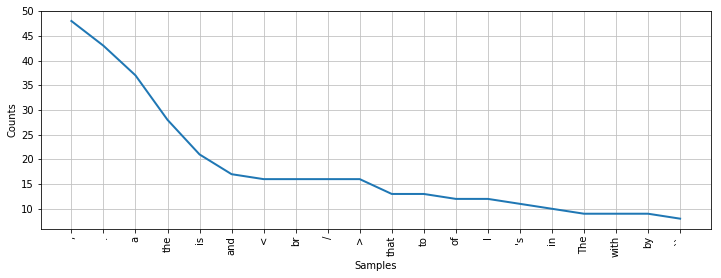

In [6]:
dist = FreqDist(corpus)
dist.most_common(20)
plt.figure(figsize=[12,4])
dist.plot(20)

In [7]:
words_occurred_only_once = [w for w in dist.most_common() if w[1]==1]
print('number of words occurred only once', len(words_occurred_only_once))

number of words occurred only once 402


### Frequency with respects to word count

In the plot below, most words in the vocabulary occurrs less than 5 times.

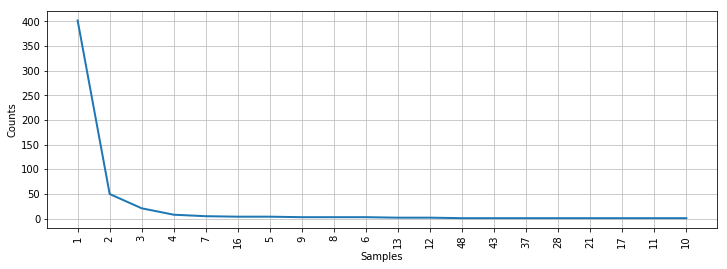

In [8]:
occurr_dist = FreqDist([w[1] for w in dist.most_common()])
plt.figure(figsize=[12,4])
occurr_dist.plot(50)

In [9]:
percent = sum([w[1] for w in occurr_dist.most_common() if w[1]<=5])/sum([w[1] for w in occurr_dist.most_common()])
print('words occurred <= 5 times in corpus:',percent)

words occurred <= 5 times in corpus: 0.06601941747572816


In [10]:
word_freq = dist.most_common()
more_than_five = dict([(w[0],i) for i, w in enumerate(word_freq) if w[1]>5])
print('len(more_than_five)', len(more_than_five))

len(more_than_five) 30


In [11]:
n = len(more_than_five)
le_than_five = dict([(w[0],n) for w in word_freq if w[1]<=5])
print('len(le_than_five)', len(le_than_five))

len(le_than_five) 485


In [12]:
word_2_int = dict(more_than_five, **le_than_five)
int_2_word = dict([(v,k) for k,v in word_2_int.items()])
int_2_word[n] = '**unknown**'

In [13]:
n_embedding = len(int_2_word)
print('n_embedding', n_embedding)

n_embedding 31


#### Test implementation 1

In [132]:
class SkipGramWordVectorNet(nn.Module):
    def __init__(self, n_embedding, embedding_freq, negative_sampling_size=10, embedding_dim=5):
        #n_embedding: vocabulary size
        #embedding_freq: used for negative sampling
        #negative_sampling_size: how many negative samples to be used
        #embedding_dim: dimension of word vectors
        
        super(SkipGramWordVectorNet,self).__init__()
        self.n_embedding = n_embedding
        self.embedding_freq = Variable(torch.Tensor(embedding_freq)**(0.75))
        self.negative_sampling_size = negative_sampling_size
        self.word_embedding = nn.Embedding(n_embedding,embedding_dim)
        self.context_embedding = nn.Embedding(n_embedding,embedding_dim)
        
    def forward(self, input):
        #return embedding
        
        return self.word_embedding(input) + self.context_embedding(input)
    
    def calculate_loss(self, word, context,alpha=0.1):
        #word.size() batch_size
        #context.size() batch_size*window_size
        
        word_pos = word.view(-1,1).expand_as(context)
        word_pos = self.word_embedding(word_pos)
        context = self.context_embedding(context)
        product_pos = (word_pos*context).sum(dim=-1).mean()
        target_pos = Variable(torch.ones(product_pos.size()))
        loss_positive = nn.functional.binary_cross_entropy_with_logits(product_pos,target_pos)
        
        #negative sampling
        negative_context = self.embedding_freq.multinomial(
            self.negative_sampling_size*context.size(0)*context.size(1), replacement=True)        
        negative_context = negative_context.view(-1,self.negative_sampling_size*context.size(1))
        
        word_neg = word.view(-1,1).expand_as(negative_context)
        word_neg = self.word_embedding(word_neg)
        negative_context = self.context_embedding(negative_context)
        
        product_neg = (word_neg*negative_context).sum(dim=-1).mean()
        target_neg = Variable(torch.zeros(product_neg.size()))
        
        loss_negative = nn.functional.binary_cross_entropy_with_logits(product_neg,target_neg)
        
#         # l2 regularization
#         loss_l2 = sum([(w**2).sum(dim=-1).mean() 
#                        for w in (word_pos,context,word_neg,negative_context)])
#         loss_l2 = loss_l2*alpha
#         loss = loss_positive + loss_negative + loss_l2
        loss = loss_positive + loss_negative
        return loss

#### Inspect

In [205]:
class SkipGramWordVectorNet(nn.Module):
    def __init__(self, n_embedding, embedding_freq, negative_sampling_size=10, embedding_dim=5):
        #n_embedding: vocabulary size
        #embedding_freq: used for negative sampling
        #negative_sampling_size: how many negative samples to be used
        #embedding_dim: dimension of word vectors
        
        super(SkipGramWordVectorNet,self).__init__()
        self.n_embedding = n_embedding
        self.embedding_freq = Variable(torch.Tensor(embedding_freq)**(0.75))
        self.negative_sampling_size = negative_sampling_size
        self.word_embedding = nn.Embedding(n_embedding,embedding_dim)
        self.context_embedding = nn.Embedding(n_embedding,embedding_dim)
        
    def forward(self, input):
        #return embedding
        torch.manual_seed(777)
        return self.word_embedding(input) + self.context_embedding(input)
    
    def calculate_loss(self, word, context,alpha=0.1):
        #word.size() batch_size
        #context.size() batch_size*window_size
        word_pos = word.view(-1,1).expand_as(context)
        word_pos = self.word_embedding(word_pos)
        print("WORD EMBBEDING:")
        print(word_pos)
        print()
        context = self.context_embedding(context)
        print("CONTEXT EMBBEDING:")
        print(context)
        print()        
        product_pos = (word_pos*context).sum(dim=-1)
        print("PRODUCT POS:")
        print(product_pos)
        print()      
        print("DOT PRODUCT")
        print(context[0][0])
        print(word_pos[0][0])
        print(torch.dot(context[0][0].view(-1), word_pos[0][0].view(-1)))
        target_pos = Variable(torch.ones(product_pos.size()))
        print("TARGET POS:")
        print(target_pos)
        print()         
        loss_positive = nn.functional.binary_cross_entropy_with_logits(product_pos,target_pos)
        print("LOSS POS:")
        print(loss_positive)
        print()           
        print("-----------------------------------------------")
        
        #negative sampling
        negative_context = self.embedding_freq.multinomial(
            self.negative_sampling_size*context.size(0)*context.size(1), replacement=True)        
        negative_context = negative_context.view(-1,self.negative_sampling_size*context.size(1))
        
        word_neg = word.view(-1,1).expand_as(negative_context)
        word_neg = self.word_embedding(word_neg)
        negative_context = self.context_embedding(negative_context)
        
        product_neg = (word_neg*negative_context).sum(dim=-1).mean()
        target_neg = Variable(torch.zeros(product_neg.size()))
        
        loss_negative = nn.functional.binary_cross_entropy_with_logits(product_neg,target_neg)
        
#         # l2 regularization
#         loss_l2 = sum([(w**2).sum(dim=-1).mean() 
#                        for w in (word_pos,context,word_neg,negative_context)])
#         loss_l2 = loss_l2*alpha
#         loss = loss_positive + loss_negative + loss_l2
        loss = loss_positive + loss_negative
        return loss

### Batch generator

In [218]:
def batch_generator(batch_size=100,window_size=5):
    torch.manual_seed(7777)
    np.random.seed(777)
    n_corpus = len(corpus)
    int_corpus = np.array([word_2_int[word] for word in corpus])
    batches = np.random.permutation(range(window_size,n_corpus-window_size))
    batches = torch.from_numpy(batches).split(batch_size)
    
    for word in batches:
        torch.manual_seed(7777)
        np.random.seed(777)
        word = np.reshape(word.numpy(),[-1,1])
        context = np.concatenate([word-i for i in range(-window_size, window_size+1) if i != 0],axis=1)
        word = int_corpus[word]
        context = int_corpus[context]
        word = Variable(torch.from_numpy(word))
        context = Variable(torch.from_numpy(context))
        yield word, context

### Train

In [219]:
#average frequency for word appeared less than five times
le_than_five_freq = sum([w[1] for w in word_freq if w[1]<=5])/len(le_than_five)
embedding_freq = [w[1] for w in word_freq if w[1]>5] +[le_than_five_freq,]
#normalize the probability
embedding_freq = np.array(embedding_freq)/sum(embedding_freq)

In [223]:
torch.manual_seed(7777)
net = SkipGramWordVectorNet(n_embedding, embedding_freq,embedding_dim=3)
optimizer = optim.Adam(net.parameters(),lr=0.001)

max_epoch = 3
batch_size = 5
window_size = 2

loss_save = []
last_max = 0
for epoch in range(max_epoch):
    g = batch_generator(batch_size, window_size)
    epoch_loss = []
    last_param = 0
    for idx, (word, context) in enumerate(g):
        if idx == 0:
            print("WORD:")
            print(word)
            print()
            print("CONTEXT:")
            print(context)
            print()
        optimizer.zero_grad()
        loss = net.calculate_loss(word, context,alpha=0)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    epoch_loss = np.mean(epoch_loss)
    loss_save.append(epoch_loss)
    if epoch%1 == 0:
        print('epoch {}, epoch_loss {}'.format(epoch, epoch_loss))

WORD:
tensor([[ 30],
        [ 19],
        [ 30],
        [ 30],
        [ 30]])

CONTEXT:
tensor([[  1,  30,  30,  24],
        [ 30,  30,  30,  10],
        [ 30,  14,  28,  30],
        [ 30,   5,   0,  30],
        [  2,  30,  30,  30]])

WORD EMBBEDING:
tensor([[[ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352]],

        [[-0.3980,  1.4784,  0.6966],
         [-0.3980,  1.4784,  0.6966],
         [-0.3980,  1.4784,  0.6966],
         [-0.3980,  1.4784,  0.6966]],

        [[ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352]],

        [[ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352]],

        [[ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [ 1.4480, -0.7579,  0.5352],
         [

WORD EMBBEDING:
tensor([[[ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490]],

        [[ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490]],

        [[ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490]],

        [[ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490]],

        [[ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490],
         [ 1.4471, -0.7519,  0.5490]]])

CONTEXT EMBBEDING:
tensor([[[ 0.0640,  0.3608,  0.9844],
         [-2.0852, -1.0566,  0.4654],
         [ 0.4319, -0.3595, -0.0687],
         [ 0.7529,  0.4092,  0.8278]],

        [[-2.0852, -1.0566,  0.4654],
  

tensor([[[ 0.3980,  0.4886,  1.0891],
         [ 0.3980,  0.4886,  1.0891],
         [ 0.3980,  0.4886,  1.0891],
         [ 0.3980,  0.4886,  1.0891]],

        [[ 1.0612, -0.9980, -1.2674],
         [ 1.0612, -0.9980, -1.2674],
         [ 1.0612, -0.9980, -1.2674],
         [ 1.0612, -0.9980, -1.2674]],

        [[ 1.4470, -0.7454,  0.5653],
         [ 1.4470, -0.7454,  0.5653],
         [ 1.4470, -0.7454,  0.5653],
         [ 1.4470, -0.7454,  0.5653]],

        [[-0.0030,  2.3131, -0.3803],
         [-0.0030,  2.3131, -0.3803],
         [-0.0030,  2.3131, -0.3803],
         [-0.0030,  2.3131, -0.3803]],

        [[-1.0667, -0.5083, -0.4461],
         [-1.0667, -0.5083, -0.4461],
         [-1.0667, -0.5083, -0.4461],
         [-1.0667, -0.5083, -0.4461]]])

CONTEXT EMBBEDING:
tensor([[[ 1.9197,  2.8701,  0.8192],
         [-0.1268,  1.0833,  0.5435],
         [-0.2761,  0.5417,  0.0173],
         [ 1.9197,  2.8701,  0.8192]],

        [[-0.8470, -0.3236, -0.1238],
         [-0.2761,

WORD EMBBEDING:
tensor([[[ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850]],

        [[ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850]],

        [[ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850]],

        [[ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850]],

        [[ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850],
         [ 1.4483, -0.7359,  0.5850]]])

CONTEXT EMBBEDING:
tensor([[[ 0.1697, -1.7873,  0.2810],
         [ 0.7913,  0.3701,  0.8125],
         [-0.0739, -1.0256, -0.7165],
         [ 0.7913,  0.3701,  0.8125]],

        [[ 0.7913,  0.3701,  0.8125],
  

WORD EMBBEDING:
tensor([[[ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014]],

        [[ 0.1525, -0.6611, -1.4645],
         [ 0.1525, -0.6611, -1.4645],
         [ 0.1525, -0.6611, -1.4645],
         [ 0.1525, -0.6611, -1.4645]],

        [[ 0.6997, -1.1050, -2.3318],
         [ 0.6997, -1.1050, -2.3318],
         [ 0.6997, -1.1050, -2.3318],
         [ 0.6997, -1.1050, -2.3318]],

        [[ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014]],

        [[ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014],
         [ 1.4531, -0.7272,  0.6014]]])

CONTEXT EMBBEDING:
tensor([[[ 0.8123,  0.3493,  0.8053],
         [ 0.8123,  0.3493,  0.8053],
         [ 0.1168, -1.3715, -1.2359],
         [ 0.8123,  0.3493,  0.8053]],

        [[-0.0746, -1.5444,  0.3209],
  

tensor([[[ 0.8268,  0.3358,  0.8054],
         [-2.0750, -1.0539,  0.4775],
         [ 0.8268,  0.3358,  0.8054],
         [ 0.3913, -0.3191, -0.0567]],

        [[ 0.8268,  0.3358,  0.8054],
         [ 0.8268,  0.3358,  0.8054],
         [ 0.8268,  0.3358,  0.8054],
         [ 0.8268,  0.3358,  0.8054]],

        [[ 0.3913, -0.3191, -0.0567],
         [ 0.8268,  0.3358,  0.8054],
         [ 0.8268,  0.3358,  0.8054],
         [ 0.8268,  0.3358,  0.8054]],

        [[ 0.1227, -1.7421,  0.2624],
         [ 0.4375, -0.8526,  0.7760],
         [ 0.8268,  0.3358,  0.8054],
         [ 0.8268,  0.3358,  0.8054]],

        [[ 0.8268,  0.3358,  0.8054],
         [ 0.8268,  0.3358,  0.8054],
         [-1.5073,  0.4824,  0.6974],
         [-2.0750, -1.0539,  0.4775]]])

PRODUCT POS:
tensor([[ 1.4584, -1.9749,  1.4584,  0.7671],
        [ 0.7485,  0.7485,  0.7485,  0.7485],
        [-0.0132, -0.2193, -0.2193, -0.2193],
        [ 1.5988,  1.7308,  1.4584,  1.4584],
        [ 1.4584,  1.4584, -2.12

WORD EMBBEDING:
tensor([[[ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308]],

        [[-1.0344, -0.4830, -0.4167],
         [-1.0344, -0.4830, -0.4167],
         [-1.0344, -0.4830, -0.4167],
         [-1.0344, -0.4830, -0.4167]],

        [[ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308]],

        [[ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308]],

        [[ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308],
         [ 1.4579, -0.7255,  0.6308]]])

CONTEXT EMBBEDING:
tensor([[[ 0.8468,  0.3164,  0.8007],
         [ 0.8468,  0.3164,  0.8007],
         [ 0.8468,  0.3164,  0.8007],
         [ 0.0910, -1.3511, -1.2340]],

        [[ 0.8468,  0.3164,  0.8007],
  

WORD EMBBEDING:
tensor([[[ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504]],

        [[ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504]],

        [[-0.0361,  0.8322, -0.4521],
         [-0.0361,  0.8322, -0.4521],
         [-0.0361,  0.8322, -0.4521],
         [-0.0361,  0.8322, -0.4521]],

        [[ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504]],

        [[ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504],
         [ 1.4587, -0.7218,  0.6504]]])

CONTEXT EMBBEDING:
tensor([[[ 1.0860,  1.4990, -0.6842],
         [ 0.8643,  0.3048,  0.7933],
         [ 0.8643,  0.3048,  0.7933],
         [ 0.0993, -0.7859, -0.8728]],

        [[ 0.8643,  0.3048,  0.7933],
  

KeyboardInterrupt: 

In [231]:
a = torch.FloatTensor([[[1.4480, -0.7579,  0.5352]],
         [[-0.3980,  1.4784,  0.6966]],
         [[1.4480, -0.7579,  0.5352]],
         [[1.4480, -0.7579,  0.5352]],
         [[1.4480, -0.7579,  0.5352]]])

In [228]:
a.size()

torch.Size([5, 1, 3])

In [121]:
a = torch.FloatTensor([[0.4371, -0.9129, -0.9725]])

In [232]:
b = torch.FloatTensor([[[ 0.4441, -0.3702, -0.0686],
         [ 0.7336,  0.4268,  0.8316],
         [ 0.7336,  0.4268,  0.8316],
         [-0.3385,  0.4290,  0.7550]],

        [[ 0.7336,  0.4268,  0.8316],
         [ 0.7336,  0.4268,  0.8316],
         [ 0.7336,  0.4268,  0.8316],
         [ 0.1555, -1.3961, -1.2378]],

        [[ 0.7336,  0.4268,  0.8316],
         [ 0.2102, -0.8790, -0.8205],
         [ 0.0763,  0.3510,  0.9942],
         [ 0.7336,  0.4268,  0.8316]],

        [[ 0.7336,  0.4268,  0.8316],
         [-2.7201, -1.9192, -0.0218],
         [-2.0896, -1.0511,  0.4619],
         [ 0.7336,  0.4268,  0.8316]],

        [[ 0.2335, -1.8465,  0.3123],
         [ 0.7336,  0.4268,  0.8316],
         [ 0.7336,  0.4268,  0.8316],
         [ 0.7336,  0.4268,  0.8316]]])

In [225]:
b.size()

torch.Size([5, 4, 3])

In [229]:
b.transpose(1,2).size()

torch.Size([5, 3, 4])

In [109]:
b = torch.FloatTensor([[ -0.7962, -0.4055, -1.0546]])

In [123]:
(a*b).sum(dim=-1)

tensor([-0.8249,  0.5619,  0.1351, -0.5512])

In [124]:
torch.dot(torch.FloatTensor([0.6153, -1.7982, -0.6617]),torch.FloatTensor([ -0.7962, -0.4055, -1.0546]))

tensor(0.9371)

In [235]:
torch.bmm(a, b.transpose(1,2))

tensor([[[ 0.8869,  1.1839,  1.1839, -0.4112]],

        [[ 0.9183,  0.9183,  0.9183, -2.9881]],

        [[ 1.1839,  0.5314,  0.3766,  1.1839]],

        [[ 1.1839, -2.4958, -1.9819,  1.1839]],

        [[ 1.9047,  1.1839,  1.1839,  1.1839]]])

In [ ]:
[[ 0.8869,  1.1838,  1.1838, -0.4113],
        [ 0.9183,  0.9183,  0.9183, -2.9882],
        [ 1.1838,  0.5314,  0.3764,  1.1838],
        [ 1.1838, -2.4958, -1.9819,  1.1838],
        [ 1.9046,  1.1838,  1.1838,  1.1838]]

In [18]:
np.random.seed(777)
n_corpus = len(corpus)
int_corpus = np.array([word_2_int[word] for word in corpus])

In [19]:
batches = np.random.permutation(range(3,n_corpus-3))
batches

array([3053781,  429510, 3207501, ..., 2280361, 2571838, 1374314])

In [20]:
batches = torch.from_numpy(batches).split(10)
batches

(tensor([ 3.0538e+06,  4.2951e+05,  3.2075e+06,  3.2226e+06,  8.4362e+05,
          9.7465e+05,  3.4006e+06,  1.2154e+06,  2.4689e+05,  3.2962e+06]),
 tensor([ 1.4874e+06,  3.4386e+06,  2.1290e+06,  3.6567e+05,  1.8231e+06,
          2.0597e+06,  3.1372e+06,  2.3958e+06,  1.7099e+06,  1.9304e+05]),
 tensor([ 3.1514e+06,  3.2860e+06,  3.3375e+06,  3.2292e+05,  3.0712e+06,
          2.0704e+06,  1.6385e+06,  8.3061e+05,  1.7599e+06,  6.2107e+05]),
 tensor([ 2.6420e+06,  3.3688e+06,  2.2592e+06,  2.5278e+05,  1.4381e+06,
          3.1055e+06,  4.4908e+05,  1.5212e+06,  3.2192e+06,  2.9306e+06]),
 tensor([ 2.5846e+06,  2.0530e+05,  3.2006e+06,  2.7039e+06,  1.3609e+05,
          1.4924e+06,  6.1231e+05,  2.4600e+06,  1.8442e+06,  2.7170e+06]),
 tensor([ 3.0461e+06,  3.0502e+06,  1.7573e+06,  2.1601e+06,  3.2197e+06,
          5.1901e+05,  2.7965e+06,  8.6191e+05,  4.8932e+05,  1.0145e+06]),
 tensor([ 1.7952e+06,  1.9967e+06,  1.2864e+06,  2.2674e+06,  2.5986e+06,
          3.2362e+05,  4.3

In [112]:
for word in batches[:10]:
    word = np.reshape(word.numpy(),[-1,1])
    print(word)
    print("---")
    context = np.concatenate([word-i for i in range(-2, 2+1) if i != 0],axis=1)
    print(context)
    print("---")    
    word = int_corpus[word]
    print(word)
    print("---")
    context = int_corpus[context]
    print(context)
    print("---")     
    print()    
    word = Variable(torch.from_numpy(word))
    context = Variable(torch.from_numpy(context))
    print(word, context)

[[3053781]
 [ 429510]
 [3207501]
 [3222620]
 [ 843615]
 [ 974648]
 [3400586]
 [1215354]
 [ 246891]
 [3296220]]
---
[[3053783 3053782 3053780 3053779]
 [ 429512  429511  429509  429508]
 [3207503 3207502 3207500 3207499]
 [3222622 3222621 3222619 3222618]
 [ 843617  843616  843614  843613]
 [ 974650  974649  974647  974646]
 [3400588 3400587 3400585 3400584]
 [1215356 1215355 1215353 1215352]
 [ 246893  246892  246890  246889]
 [3296222 3296221 3296219 3296218]]
---
[[   19]
 [   11]
 [  122]
 [10292]
 [    0]
 [    0]
 [    6]
 [   51]
 [   32]
 [ 5231]]
---
[[21844 21844  5370  1347]
 [    9     8    10     9]
 [   14     2   112   107]
 [ 4499     1     4   761]
 [   15   189    12   113]
 [  332   663   392   135]
 [ 2224  2292   454     7]
 [  113   120  3876    57]
 [   22   355    42     1]
 [   36     1   649     5]]
---

tensor([[    19],
        [    11],
        [   122],
        [ 10292],
        [     0],
        [     0],
        [     6],
        [    51],
        [    32

In [113]:
word_embedding = nn.Embedding(21845,3)
context_embedding = nn.Embedding(21845,3)

In [93]:
word

tensor([[  105],
        [    4],
        [    2],
        [  120],
        [ 3516],
        [   56],
        [ 3282],
        [   23],
        [   58],
        [   52]])

In [114]:
context

tensor([[    33,     64,     33,    540],
        [   109,    974,     12,    555],
        [     3,   1502,   2504,   1020],
        [    62,   1926,      1,  11128],
        [    41,   4905,  21844,    217],
        [   673,     91,      2,     39],
        [    12,   2524,      3,   2365],
        [  2731,   2063,    702,    896],
        [   503,    398,      4,   2736],
        [     2,     13,     51,     14]])

In [94]:
word_pos = word.view(-1,1).expand_as(context)
word_pos

tensor([[  105,   105,   105,   105],
        [    4,     4,     4,     4],
        [    2,     2,     2,     2],
        [  120,   120,   120,   120],
        [ 3516,  3516,  3516,  3516],
        [   56,    56,    56,    56],
        [ 3282,  3282,  3282,  3282],
        [   23,    23,    23,    23],
        [   58,    58,    58,    58],
        [   52,    52,    52,    52]])

In [95]:
word_pos = word_embedding(word_pos)
word_pos

tensor([[[ 0.8473, -1.0580,  1.5377],
         [ 0.8473, -1.0580,  1.5377],
         [ 0.8473, -1.0580,  1.5377],
         [ 0.8473, -1.0580,  1.5377]],

        [[-0.4542,  0.3986,  0.9006],
         [-0.4542,  0.3986,  0.9006],
         [-0.4542,  0.3986,  0.9006],
         [-0.4542,  0.3986,  0.9006]],

        [[ 1.2408,  1.0654,  1.2224],
         [ 1.2408,  1.0654,  1.2224],
         [ 1.2408,  1.0654,  1.2224],
         [ 1.2408,  1.0654,  1.2224]],

        [[-0.4760,  0.4435, -0.2567],
         [-0.4760,  0.4435, -0.2567],
         [-0.4760,  0.4435, -0.2567],
         [-0.4760,  0.4435, -0.2567]],

        [[ 0.4210,  0.4195, -1.1163],
         [ 0.4210,  0.4195, -1.1163],
         [ 0.4210,  0.4195, -1.1163],
         [ 0.4210,  0.4195, -1.1163]],

        [[ 2.0361,  0.0165,  1.6437],
         [ 2.0361,  0.0165,  1.6437],
         [ 2.0361,  0.0165,  1.6437],
         [ 2.0361,  0.0165,  1.6437]],

        [[ 0.4908,  0.1612, -0.7007],
         [ 0.4908,  0.1612, -0.7007],


In [96]:
context = context_embedding(context)

Word 0 (embbeded)

In [192]:
word_embedding(word[0]).t().squeeze()

tensor([ 0.4515,  0.4835, -0.0893])

Context word 0 (embbeded)

In [193]:
context_embedding(context[0][0])

tensor([ 1.3559,  1.3604, -0.7206])

In [176]:
context_embedding(context[0])

tensor([[ 1.3559,  1.3604, -0.7206],
        [ 0.7510, -0.2649,  0.6977],
        [ 1.3559,  1.3604, -0.7206],
        [ 1.6904,  1.0222,  1.5776]])

 Dot product between word 0 embbeding and context word 0 embbeding

In [256]:
word_embedding(word[0]).t().size()

torch.Size([3, 1])

In [250]:
context_embedding(context[0][0]).size()

torch.Size([3])

In [274]:
torch.dot(word_embedding(word[0]).t().squeeze(), context_embedding(context[0][0]))

tensor(1.3343)

In [177]:
word_embedding(word[0]).expand_as(context_embedding(context[0]))

tensor([[ 0.4515,  0.4835, -0.0893],
        [ 0.4515,  0.4835, -0.0893],
        [ 0.4515,  0.4835, -0.0893],
        [ 0.4515,  0.4835, -0.0893]])

Batch matrix multiplication between word 0 embbeding and every context word embbeding for word 0

In [277]:
torch.mul(word_embedding(word[0]).expand_as(context_embedding(context[0])), 
          context_embedding(context[0])).sum(dim=-1)

tensor([ 1.3343,  0.1487,  1.3343,  1.1165])

The same batch matrix multiplication but with a dedicated function

In [276]:
torch.bmm(word_embedding(word[0]).expand_as(context_embedding(context[0])).unsqueeze(0), 
          context_embedding(context[0]).t().unsqueeze(0))

tensor([[[ 1.3343,  0.1487,  1.3343,  1.1165],
         [ 1.3343,  0.1487,  1.3343,  1.1165],
         [ 1.3343,  0.1487,  1.3343,  1.1165],
         [ 1.3343,  0.1487,  1.3343,  1.1165]]])

In [278]:
context_embedding(context[0]).t().unsqueeze(0)

tensor([[[ 1.3559,  0.7510,  1.3559,  1.6904],
         [ 1.3604, -0.2649,  1.3604,  1.0222],
         [-0.7206,  0.6977, -0.7206,  1.5776]]])

In [107]:
torch.mul(word_pos[0], context[0]).sum(dim=1)

tensor([-0.0382,  2.4670, -0.0382,  0.4290])

In [81]:
(word_pos*context)

tensor([[[ 1.0124, -0.2251,  0.1365],
         [ 0.5705,  0.8132, -0.0775],
         [ 1.0124, -0.2251,  0.1365],
         [ 1.2207, -0.2637,  0.0283]],

        [[ 0.0033, -0.1937, -0.2919],
         [-0.4074, -0.2236,  0.7307],
         [-0.2269, -0.0410,  0.4283],
         [ 0.1946,  0.2153,  0.9206]],

        [[ 0.1875, -0.1162,  0.0001],
         [ 0.7909, -0.1472,  0.0007],
         [ 0.0860, -0.2768,  0.0017],
         [-0.6496,  0.2786, -0.0007]],

        [[-0.4251,  0.0673,  0.1913],
         [-1.9627,  0.0045, -0.0995],
         [ 1.0520, -0.1904, -0.2557],
         [ 1.0593, -0.0921, -0.0794]],

        [[ 0.5084,  0.6072, -0.7085],
         [-0.2246,  0.4155,  0.4618],
         [-0.1438, -1.3932, -0.3145],
         [ 0.2317, -0.7683,  0.5132]],

        [[ 1.5963,  0.2819, -0.0029],
         [ 0.3904,  0.0430,  0.5722],
         [-0.9414, -0.2303, -0.3152],
         [ 0.8563,  0.0134,  1.3875]],

        [[ 0.9039,  0.0319, -1.3425],
         [-0.1538, -0.0449, -1.8629],


In [80]:
(word_pos*context).sum(dim=-1)

tensor([[ 0.9238,  1.3062,  0.9238,  0.9854],
        [-0.4823,  0.0997,  0.1604,  1.3304],
        [ 0.0715,  0.6443, -0.1891, -0.3717],
        [-0.1665, -2.0577,  0.6058,  0.8877],
        [ 0.4070,  0.6527, -1.8515, -0.0235],
        [ 1.8753,  1.0057, -1.4869,  2.2572],
        [-0.4067, -2.0616,  0.4167,  0.6431],
        [ 0.0401, -0.0845,  0.4593, -0.1350],
        [ 2.8086,  0.9361, -1.8428, -0.0766],
        [-0.8231,  0.4060, -1.1106,  1.9005]])

In [ ]:
product_pos = (word_pos*context).sum(dim=-1).mean()
target_pos = Variable(torch.ones(product_pos.size()))
loss_positive = nn.functional.binary_cross_entropy_with_logits(product_pos,target_pos)

In [99]:
word

tensor([[  1326],
        [ 14502],
        [    32],
        [ 11770],
        [     7],
        [    43]])

In [100]:
word.view(-1,1).expand_as(context)

tensor([[  1326,   1326,   1326,   1326],
        [ 14502,  14502,  14502,  14502],
        [    32,     32,     32,     32],
        [ 11770,  11770,  11770,  11770],
        [     7,      7,      7,      7],
        [    43,     43,     43,     43]])

PyTorch batch generator

In [ ]:
sample_size = len(y)
train_size = int(0.9*sample_size)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, drop_last=True)

print (len(X)/batch_size)
print(len(train_loader) + len(val_loader))

tensor([   349,      4,     26,     15,    243,    110,   1177,     75,
           329,     32,      4,    178,      5,    682,   4689,   4608,
            22,     17,   1055,      2,   6699,      4,     26,    137,
           803,  11770,      7,    210,    198,     40,   5607,  14502,
             7,      4,    151,  13675,      2,     21,  21844,    124,
             7,     43,   1802,   4456,      2,   1193,     22,   1326,
            31,     21])

In [79]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(int_corpus[:50]))

In [82]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, num_workers=1, shuffle=True,drop_last=True)
print (len(torch.from_numpy(int_corpus[:50]))/10)

5.0


In [97]:
torch.manual_seed(77)
for batch_idx, data in enumerate(train_loader):
    print(batch_idx, data)

0 [tensor([  329,  4689,  1193,  1802,  5607,    40,     7,    21,     4,
           22])]
1 [tensor([    32,      2,   6699,  13675,     22,     26,   4608,    151,
           124,    198])]
2 [tensor([  803,   110,    31,    21,  4456,     2,     5,     2,     7,
         1177])]
3 [tensor([   349,   1055,      4,    210,     15,  21844,     75,      4,
          1326,  14502])]
4 [tensor([    17,    243,      7,     26,     43,    178,    682,    137,
         11770,      4])]


#### Test implementation 2

In [92]:
class SkipGramModel(nn.Module):
    """Skip gram model of word2vec.
    Attributes:
        emb_size: Embedding size.
        emb_dimention: Embedding dimention, typically from 50 to 500.
        u_embedding: Embedding for center word.
        v_embedding: Embedding for neibor words.
    """

    def __init__(self, emb_size, emb_dimension):
        """Initialize model parameters.
        Apply for two embedding layers.
        Initialize layer weight
        Args:
            emb_size: Embedding size.
            emb_dimention: Embedding dimention, typically from 50 to 500.
        Returns:
            None
        """
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.init_emb()

    def init_emb(self):
        """Initialize embedding weight like word2vec.
        The u_embedding is a uniform distribution in [-0.5/em_size, 0.5/emb_size], and the elements of v_embedding are zeroes.
        Returns:
            None
        """
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, pos_u, pos_v, neg_v):
        """Forward process.
        As pytorch designed, all variables must be batch format, so all input of this method is a list of word id.
        Args:
            pos_u: list of center word ids for positive word pairs.
            pos_v: list of neibor word ids for positive word pairs.
            neg_u: list of center word ids for negative word pairs.
            neg_v: list of neibor word ids for negative word pairs.
        Returns:
            Loss of this process, a pytorch variable.
        """
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        score = torch.mul(emb_u, emb_v).squeeze()
        score = torch.sum(score, dim=1)
        score = F.logsigmoid(score)
        neg_emb_v = self.v_embeddings(neg_v)
        neg_score = torch.bmm(neg_emb_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = F.logsigmoid(-1 * neg_score)
        return -1 * (torch.sum(score)+torch.sum(neg_score))

In [ ]:
def test():
    model = SkipGramModel(100, 100)
    id2word = dict()
    for i in range(100):
        id2word[i] = str(i)

### Selecting Negative Samples

The “negative samples” (that is, the 5 output words that we’ll train to output 0) are chosen using a “unigram distribution”.

Essentially, the probability for selecting a word as a negative sample is related to its frequency, with more frequent words being more likely to be selected as negative samples.

In the word2vec C implementation, you can see the equation for this probability. Each word is given a weight equal to it’s frequency (word count) raised to the 3/4 power. The probability for a selecting a word is just it’s weight divided by the sum of weights for all words:

$$P(w_i) = \frac{  {f(w_i)}^{3/4}  }{\sum_{j=0}^{n}\left(  {f(w_j)}^{3/4} \right) }$$

Source: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

In [412]:
# Word frequency and word - ID mappings
word_frequency = dict(FreqDist(corpus))
word2id = {word: i for i, word in enumerate(corpus)}
id2word = {i: word for i, word in enumerate(corpus)}
word_count = len(word2id)

In [413]:
# Probability for a given word i in the corpus
pow_frequency = np.array(list(word_frequency.values()))**0.75
words_pow = sum(pow_frequency) 
p_wi = pow_frequency / words_pow

The way this selection is implemented in the C code is interesting. <br>
They have a large array with 100M elements (which they refer to as the unigram table). They fill this table with the index of each word in the vocabulary multiple times - the number of times a word’s index appears in the table is given by P(wi) * table_size. <br>
Then, to actually select a negative sample, you just generate a random integer between 0 and 100M, and use the word at that index in the table. <br>
Since the higher probability words occur more times in the table, you’re more likely to pick those.

Source: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

In [414]:
sample_table = []
sample_table_size = 1e8 # empty 100 million array

# Generate "unigram" table
count = np.round(p_wi * sample_table_size) # number of times a word’s index will appear in the table

# Fill the table 
for wid, c in enumerate(count):
    sample_table += [wid] * int(c)
    
sample_table = np.array(sample_table)

#### Function to get batches of word pairs

In [415]:
def get_batch_pairs(batch_size, window_size, word_dict):
    while len(word_pair_catch) < batch_size:

        for word in list(word_dict):
            word_ids.append(word2id[word])

        for i, u in enumerate(word_ids):
            for j, v in enumerate(
                    word_ids[max(i - window_size, 0):i + window_size]):            
                if i == j:
                    continue
                word_pair_catch.append((u, v))

    batch_pairs = []
    for _ in range(batch_size):
        batch_pairs.append(word_pair_catch.popleft())     
    
    return batch_pairs

#### Function to get negative sampling batches

In [416]:
def get_neg_v_neg_sampling(batch_size, sample_table, window_size):
    np.random.seed(777)
    neg_v = np.random.choice(
        sample_table, size=(batch_size, window_size)).tolist()
    return neg_v

#### Set hyperparameters and helper lists

In [417]:
batch_size = 50
window_size = 3
word_pair_catch = deque()
word_ids = []

#### Get positive pair batches

In [418]:
pos_pairs = get_batch_pairs(batch_size, window_size, word2id)

In [419]:
[(i,j) for i,j in pos_pairs][:10]

[(3706, 10566),
 (3706, 10254),
 (10566, 3706),
 (10566, 10254),
 (10566, 10613),
 (10254, 3706),
 (10254, 10566),
 (10254, 10613),
 (10254, 10143),
 (10613, 3706)]

In [420]:
[(id2word[i], id2word[j]) for i,j in pos_pairs][:10]

[('For', 'a'),
 ('For', 'movie'),
 ('a', 'For'),
 ('a', 'movie'),
 ('a', 'that'),
 ('movie', 'For'),
 ('movie', 'a'),
 ('movie', 'that'),
 ('movie', 'gets'),
 ('that', 'For')]

In [421]:
center_words = [pair[0] for pair in pos_pairs]
target_words = [pair[1] for pair in pos_pairs]

In [422]:
center_words[:10]

[3706, 3706, 10566, 10566, 10566, 10254, 10254, 10254, 10254, 10613]

In [423]:
[id2word[i] for i in center_words[:10]]

['For', 'For', 'a', 'a', 'a', 'movie', 'movie', 'movie', 'movie', 'that']

In [424]:
[id2word[j] for j in target_words[:10]]

['a', 'movie', 'For', 'movie', 'that', 'For', 'a', 'that', 'gets', 'For']

#### Get negative samples batches

In [425]:
negative_words = get_neg_v_neg_sampling(batch_size, sample_table, window_size)

In [426]:
[i for i in negative_words[0]]

[2462, 2391, 915]

In [427]:
[id2word[i] for i in negative_words[0]]

['effectively', 'a', 'and']

In [428]:
negative_words[:10]

[[2462, 2391, 915],
 [632, 2670, 2756],
 [16, 2310, 1729],
 [321, 221, 1846],
 [288, 1995, 879],
 [1957, 79, 822],
 [1577, 2249, 651],
 [26, 2185, 21],
 [1747, 2367, 1923],
 [2360, 104, 1568]]

In [394]:
u_embeddings = torch.nn.Embedding(len(corpus), 3, sparse=True)
v_embeddings = torch.nn.Embedding(len(corpus), 3, sparse=True)

#initrange = 0.5 / 3
#u_embeddings.weight.data.uniform_(-initrange, initrange)
#v_embeddings.weight.data.uniform_(-0, 0)

In [475]:
center_embeds = u_embeddings(torch.LongTensor([center_words[:6]]))
target_embeds = v_embeddings(torch.LongTensor([target_words[:6]]))
neg_embeds = v_embeddings(torch.LongTensor([negative_words[:6]]))

In [476]:
center_embeds

tensor([[[ 1.3868,  0.7963, -1.0217],
         [ 1.3868,  0.7963, -1.0217],
         [-1.7993, -0.0838, -1.8914],
         [-1.7993, -0.0838, -1.8914],
         [-1.7993, -0.0838, -1.8914],
         [ 0.9357, -1.3684,  0.7259]]])

In [477]:
center_embeds.view(center_embeds.size()[1],1,center_embeds.size()[2])

tensor([[[ 1.3868,  0.7963, -1.0217]],

        [[ 1.3868,  0.7963, -1.0217]],

        [[-1.7993, -0.0838, -1.8914]],

        [[-1.7993, -0.0838, -1.8914]],

        [[-1.7993, -0.0838, -1.8914]],

        [[ 0.9357, -1.3684,  0.7259]]])

In [487]:
target_embeds.view(target_embeds.size()[1],1,target_embeds.size()[2])

tensor([[[ 1.0939, -0.9439,  0.8661]],

        [[-1.6979, -1.2529, -1.0985]],

        [[ 1.1373, -0.7678,  0.9288]],

        [[-1.6979, -1.2529, -1.0985]],

        [[-0.4794, -1.9533,  0.1661]],

        [[ 1.1373, -0.7678,  0.9288]]])

In [479]:
negative_words[0]

[2462, 2391, 915]

In [ ]:
center_embeds = self.embedding_v(center_words) # B x 1 x D
target_embeds = self.embedding_u(target_words) # B x 1 x D
neg_embeds = -self.embedding_u(negative_words) # K个负样本 B x K x D 

In [485]:
torch.bmm(center_embeds.view(center_embeds.size()[1],1,center_embeds.size()[2]),
          target_embeds.view(target_embeds.size()[1],1,target_embeds.size()[2]).transpose(1,2)).squeeze(2)

tensor([[-0.1195],
        [-2.2301],
        [-3.7387],
        [ 5.2377],
        [ 0.7121],
        [ 2.7890]])

In [ ]:
emb_u = self.u_embeddings(center_words)
emb_v = self.v_embeddings(target_words)
score = torch.mul(emb_u, emb_v).squeeze()
score = torch.sum(score, dim=1)
score = F.logsigmoid(score)
neg_emb_v = self.v_embeddings(negative_words)
neg_score = torch.bmm(neg_emb_v, emb_u.unsqueeze(2)).squeeze()
neg_score = F.logsigmoid(-1 * neg_score)
return -1 * (torch.sum(score)+torch.sum(neg_score))